In [1]:
%matplotlib inline
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn

import os
import argparse
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
# Check GPU
use_cuda = torch.cuda.is_available()
print(torch.cuda.current_blas_handle())
print(torch.cuda.current_stream())
print(torch.cuda.device(0))

93982282211408
<torch.cuda.Stream device=0 cuda_stream=0x0>


# Data Set
Data introducton: <br>
http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html <br>
Other dataset in pytorch<br>
http://pytorch-zh.readthedocs.io/en/latest/torchvision/datasets.html

In [4]:
print('=========> preparing data..................')
BATCH_SIZE = 128

transform_train = transforms.Compose([
          transforms.RandomCrop(32, padding=4),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))    
          ])

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True,
                                           transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, 
                                            shuffle=True, num_workers=2)

# 10 labels of dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

'''
root : given a directory to put processed/training.pt and processed/test.pt.
train : True = Training set, False = Test set
download : True = downloads the dataset from the internet and puts it in root
           directory. 
           If dataset already downloaded, place the processed dataset 
           (function available in mnist.py) in the processed folder.
num_workers : how many subprocesses to use for data loading. 0 means that the 
              data will be loaded in the main process. (default: 0)
'''

=========> preparing data..................
Files already downloaded and verified


'\nroot : given a directory to put processed/training.pt and processed/test.pt.\ntrain : True = Training set, False = Test set\ndownload : True = downloads the dataset from the internet and puts it in root\n           directory. \n           If dataset already downloaded, place the processed dataset \n           (function available in mnist.py) in the processed folder.\nnum_workers : how many subprocesses to use for data loading. 0 means that the \n              data will be loaded in the main process. (default: 0)\n'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 32, 32])
 ship   dog   cat  ship plane   car   cat plane truck  bird


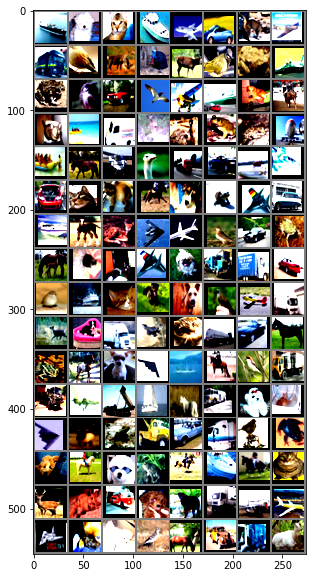

Process Process-1:
Process Process-2:
Traceback (most recent call last):
  File "/home/eric/anaconda3/envs/pytorch_gpu/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/eric/anaconda3/envs/pytorch_gpu/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/eric/anaconda3/envs/pytorch_gpu/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/eric/anaconda3/envs/pytorch_gpu/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/eric/anaconda3/envs/pytorch_gpu/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/eric/anaconda3/envs/pytorch_gpu/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/eric/anaconda3/e

In [5]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.size())

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(10)))

# Building Model
How to get the size of feature map: <br>
Output H = 1 + (input H + 2Panding - Filter H)/Stride <br>
Output W = 1 + (input W + 2Panding - Filter W)/Stride <br>

In [18]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
                    )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
                    )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, stride=1),
            #nn.MaxPool2d(kernel_size=2, stride=1),
            #nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
                    )
        
        
        # fully connected layer
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=6*6*128, out_features=500))
        
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=500, out_features=10))
            
        
    def forward(self, x):
        out = self.conv3(self.conv2(self.conv1(x)))
        out = out.view( -1, 6*6*128)
        out = self.fc2(self.fc1(out))
        return F.log_softmax(out)

In [19]:
# Setting the model & loss function & optimizer
net = CNN()
loss_func = nn.CrossEntropyLoss(size_average=False)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.99))

In [20]:
'''
if use_cuda:
    net.cuda()
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True
'''

'\nif use_cuda:\n    net.cuda()\n    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))\n    cudnn.benchmark = True\n'

# Runnung Model

In [22]:
weight = dict()
iters = 0
num_of_epoch = 100
for epoch in range(num_of_epoch):
    correct = 0
    for i, (images, labels) in enumerate(trainloader):
        # convert tensor to Variable
        images = Variable(images)
        labels = Variable(labels)

        # clear gradients w.r.t parameters
        optimizer.zero_grad()

        # forward pass
        outputs = net(images)

        # calculate loss
        loss = loss_func(outputs, labels)

        # get gradient w.r.t parameters
        loss.backward()

        # update parameters
        optimizer.step()

        iters += 1
        
        
        # Accuracy (each batch)
        pred = outputs.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(labels.data).cpu().sum()
        Acc = correct / ((i+1)*BATCH_SIZE) * 100
        if iters % 100 == 0:     
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f},  Accumulation batch acc={:.1f}%'.format(
                    epoch+1, i * len(images), len(trainloader.dataset),
                    100. * i / len(trainloader), loss.data[0], Acc))
    # Get the weight
    if epoch%3 == 0:
        for param in net.parameters():
            weight[epoch] = list(param.data)

/home/eric/anaconda3/envs/pytorch_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [12672/50000 (25%)]	Loss: 186.647812,  Accumulation batch acc=42.0%
Train Epoch: 1 [25472/50000 (51%)]	Loss: 169.788269,  Accumulation batch acc=44.6%
Train Epoch: 1 [38272/50000 (76%)]	Loss: 156.972702,  Accumulation batch acc=46.7%
Train Epoch: 2 [1024/50000 (2%)]	Loss: 163.493118,  Accumulation batch acc=52.1%
Train Epoch: 2 [13824/50000 (28%)]	Loss: 171.552063,  Accumulation batch acc=55.2%
Train Epoch: 2 [26624/50000 (53%)]	Loss: 152.880524,  Accumulation batch acc=56.7%
Train Epoch: 2 [39424/50000 (79%)]	Loss: 162.829605,  Accumulation batch acc=57.5%
Train Epoch: 3 [2176/50000 (4%)]	Loss: 133.282883,  Accumulation batch acc=61.1%
Train Epoch: 3 [14976/50000 (30%)]	Loss: 129.462906,  Accumulation batch acc=61.2%
Train Epoch: 3 [27776/50000 (55%)]	Loss: 120.976204,  Accumulation batch acc=61.6%
Train Epoch: 3 [40576/50000 (81%)]	Loss: 136.782745,  Accumulation batch acc=61.9%
Train Epoch: 4 [3328/50000 (7%)]	Loss: 161.208542,  Accumulation batch acc=64.0%
Train Epoc

Process Process-18:
Process Process-17:
Traceback (most recent call last):
  File "/home/eric/anaconda3/envs/pytorch_gpu/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/eric/anaconda3/envs/pytorch_gpu/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/eric/anaconda3/envs/pytorch_gpu/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/eric/anaconda3/envs/pytorch_gpu/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/eric/anaconda3/envs/pytorch_gpu/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/eric/anaconda3/envs/pytorch_gpu/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/er

KeyboardInterrupt: 